## Laboratorio 2 - Data Science

Stefano Aragoni, Carol Arévalo

------------------
**Objetivo del laboratorio**: Entrenar una red neuronal convolucional, utilizando la arquitectura Le-Net, para clasificar imágenes de rótulos de tráfico.

------------

### Importar Librerías

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pickle
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from graphviz import *
from keras.callbacks import EarlyStopping


------------

### Preparación de Datos
1. **Descargar el conjunto de datos de rótulos de tráfico que contiene las imágenes de las 43 clases mencionadas.**

Como primer paso, se cargaron los archivos .p a través de la librería pickle. Cabe destacar que había un archivo para el conjunto de entrenamiento, conjunto de validación y conjunto de prueba. Para cada uno de estos archivos, se cargaron las imágenes y las etiquetas correspondientes.

In [2]:
# Load data from pickle files
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

train_data = load_data('./Datos_Rotulos_Trafico/entrenamiento.p')
test_data = load_data('./Datos_Rotulos_Trafico/prueba.p')
val_data = load_data('./Datos_Rotulos_Trafico/validacion.p')

Posteriormente, se crearon diferentes Dataframes de Pandas para almacenar los datos de los archivos. Para el presente laboratorio, cabe destacar que únicamente se utilizaron las clases de labels y features. 

Labes contiene información sobre el tipo de rotulo de tráfico que se está analizando, mientras que features almacena la información de los pixeles de cada fotografía.

In [3]:
train_df = pd.DataFrame({
    'coords': train_data['coords'].tolist(),
    'labels': train_data['labels'].tolist(),
    'features': train_data['features'].tolist(),
    'sizes': train_data['sizes'].tolist()
})

test_df = pd.DataFrame({
    'coords': test_data['coords'].tolist(),
    'labels': test_data['labels'].tolist(),
    'features': test_data['features'].tolist(),
    'sizes': test_data['sizes'].tolist()
})

val_df = pd.DataFrame({
    'coords': val_data['coords'].tolist(),
    'labels': val_data['labels'].tolist(),
    'features': val_data['features'].tolist(),
    'sizes': val_data['sizes'].tolist()
})

Como se puede observar a continuación, el conjunto de datos tiene 4 columnas principales; coords, labels, features y sizes. 

En este caso, únicamente nos interesa la columna de features y labels; que contienen los pixeles de la imagen y la etiqueta de la imagen respectivamente.

In [4]:
train_df.head(-5)

,coords,labels,features,sizes
0,"[6, 5, 21, 20]",41,"[[[28, 25, 24], [27, 24, 23], [27, 24, 22], [2...","[26, 25]"
1,"[6, 6, 22, 22]",41,"[[[28, 24, 24], [26, 23, 23], [27, 24, 24], [2...","[27, 27]"
2,"[5, 6, 22, 23]",41,"[[[29, 25, 25], [29, 26, 26], [30, 27, 27], [3...","[27, 28]"
3,"[5, 6, 22, 23]",41,"[[[31, 28, 26], [29, 26, 24], [30, 27, 26], [2...","[27, 28]"
4,"[5, 6, 23, 23]",41,"[[[33, 27, 25], [31, 25, 24], [32, 26, 25], [3...","[29, 29]"
...,...,...,...,...
34789,"[11, 9, 107, 95]",25,"[[[37, 36, 42], [34, 34, 40], [37, 35, 40], [4...","[117, 104]"
34790,"[12, 9, 117, 103]",25,"[[[37, 37, 38], [32, 32, 38], [31, 31, 37], [3...","[128, 112]"
34791,"[11, 11, 123, 110]",25,"[[[70, 85, 121], [50, 51, 67], [57, 65, 84], [...","[135, 120]"
34792,"[13, 11, 132, 116]",25,"[[[48, 44, 57], [28, 30, 38], [44, 46, 53], [8...","[145, 127]"


2. **Dividir el conjunto de datos en conjuntos de entrenamiento, validación y prueba.**

En este caso, los datos ya venían pre-procesados y divididos en los conjuntos de entrenamiento, validación y prueba. Por tal razón, este paso no fue necesario realizarlo. 

Como se puede observar a continuación, de las 51,839 imagenes, 67.12% de los datos (~70%) corresponden al conjunto de entrenamiento, 24.36% (~25%) al conjunto de validación y 8.5% (~5%) al conjunto de prueba.

En base a esto, se puede concluir que las proporciones son adecuadas para el entrenamiento y la evaluación del modelo a generar. 

In [5]:
print("Tamaño train: ", train_df.shape)
print("Tamaño test: ", test_df.shape)
print("Tamaño val: ", val_df.shape)

Tamaño train:  (34799, 4)
Tamaño test:  (12630, 4)
Tamaño val:  (4410, 4)


3. **Exploración de Datos**

Posteriormente, se quiso determinar cómo estaban distribuidos los datos. En este caso, como se puede observar, se tiene un total de 43 clases diferentes; empezando de 0 a 42.

In [6]:
# Combinar todos los dataframes en uno solo
complete_df = pd.concat([train_df, test_df, val_df], axis=0)

# Lista de labels únicos
labels_unicos = complete_df['labels'].unique().tolist()
labels_unicos.sort()

print(labels_unicos)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


Como se puede observar a continuación, cada Label hace referencia a un tipo de rótulo diferente, lo cual nos permite identificar el tipo de dato que estamos tratando.

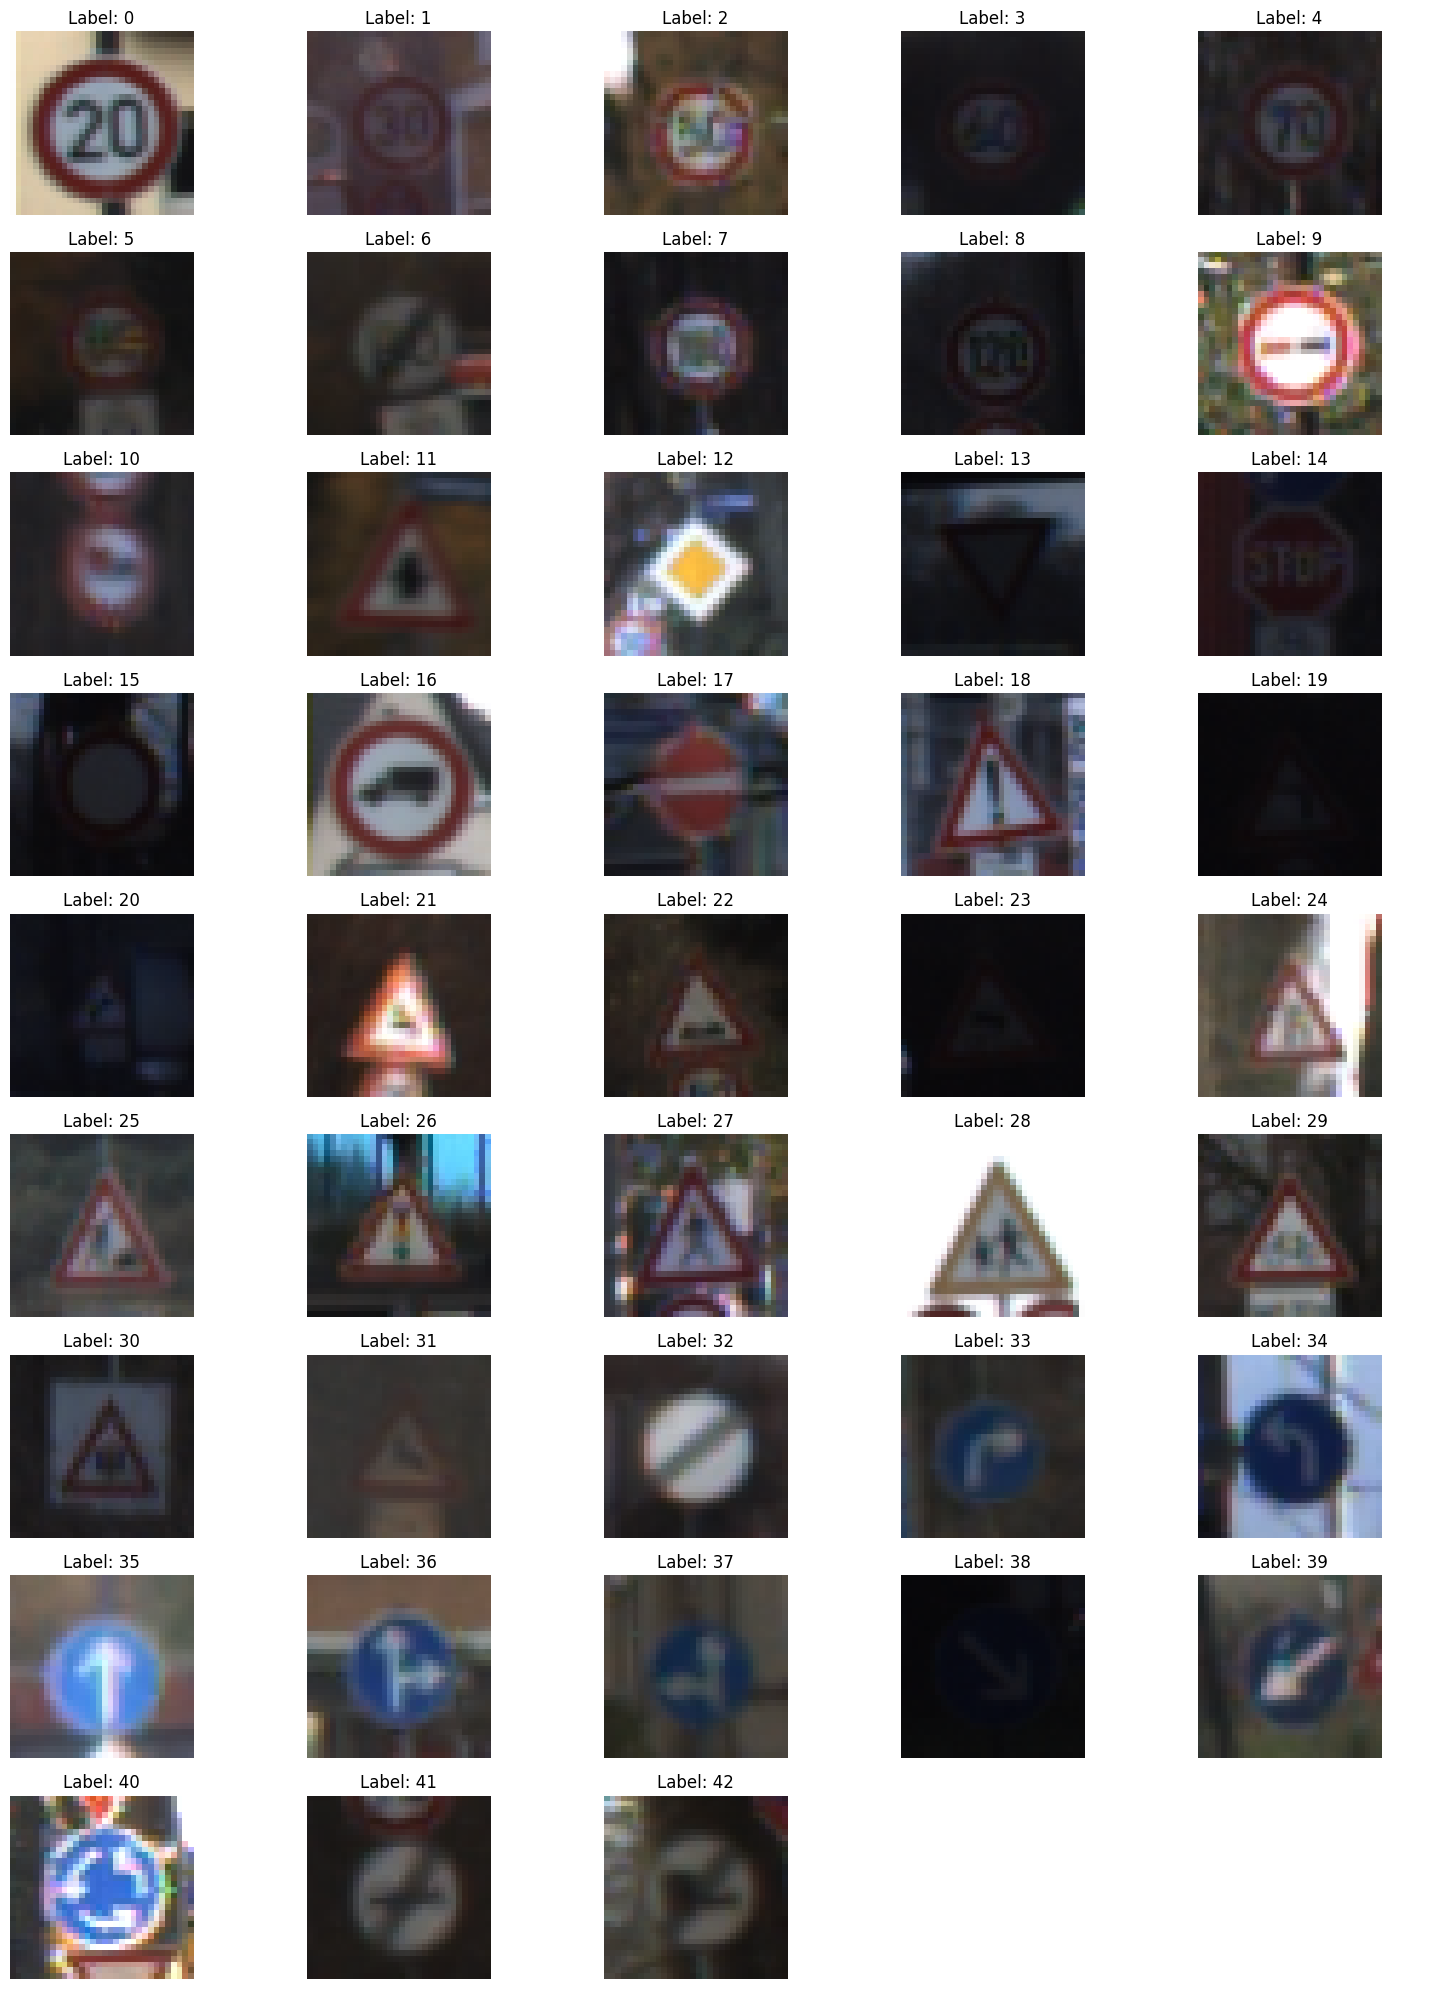

In [7]:
# Escoge una fotografia de cada clase
fotos_ejemplo = {}
for index, row in complete_df.iterrows():
    pixeles_img = row['features']
    label_img = row['labels']
    
    if label_img not in fotos_ejemplo:
        fotos_ejemplo[label_img] = pixeles_img

# Ordena las fotos por label
fotos_ejemplo = dict(sorted(fotos_ejemplo.items()))

# Muestra las fotos
fig, axes = plt.subplots(9, 5, figsize=(15, 20))
for i, ax in enumerate(axes.flat):
    if i < len(fotos_ejemplo):
        label = list(fotos_ejemplo.keys())[i]
        pixeles_img = fotos_ejemplo[label]
        
        ax.imshow(pixeles_img)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


Sin embargo, es importante mencionar que pareciera que **los datos NO se encuentran balanceados**. Sin embargo, *según el Profesor Luis Furlán, estos datos fueron previamente sometidos a Data Augmentation, y posteriormente separados en los conjuntos de entrenamiento, validación y prueba*.

En este caso, sin embargo, este desbalanceo de los datos ya procesados puede resultar en que algunas clases no sean identificadas de forma precisa. Por ejemplo, si una clase tiene 1000 imágenes y otra tiene 100, el modelo aprenderá a clasificar la primera clase con mayor precisión que la segunda, ya que tiene más ejemplos para aprender.

<AxesSubplot: title={'center': 'Cantidad de elementos por Label en el dataset de entrenamiento'}>

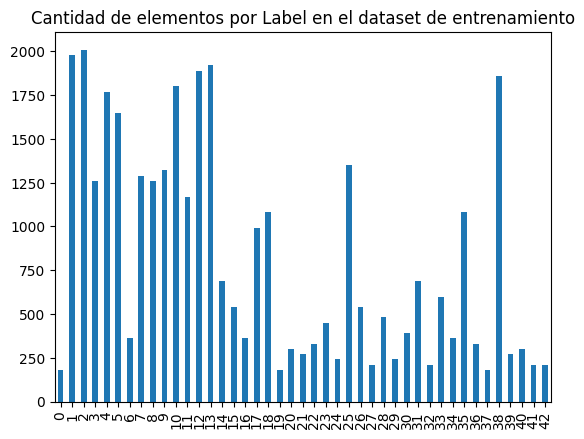

In [8]:
# Cantidad de elementos por Label en el dataset de entrenamiento
cant_elementos_train = train_df['labels'].value_counts().sort_index()

cant_elementos_train.plot(kind='bar', title='Cantidad de elementos por Label en el dataset de entrenamiento')

4. **Realizar preprocesamiento de las imágenes, como redimensionarlas a un tamaño estándar, normalización, etc**

Como se puede observar a continuación, se cargó la información de los pixeles de las fotografías a un numpy array. Posteriormente, se redimensionaron las imágenes a un tamaño de 32x32 y se normalizaron los valores de los pixeles entre 0 y 1. 

In [10]:
# Convertir a numpy array
train_df['features'] = train_df['features'].apply(np.array)
test_df['features'] = test_df['features'].apply(np.array)
val_df['features'] = val_df['features'].apply(np.array)

# Tamaño de las imagenes
target_size = (32, 32) 

# Función para preprocesar las imagenes
def preprocess_images(images, target_size):
    preprocessed_images = []
    for image in images:
        # Cambiar el tamaño de la imagen
        resized_image = cv2.resize(image, target_size)
        
        # Normalizar la imagen
        normalized_image = resized_image / 255.0
        
        preprocessed_images.append(normalized_image)
    return preprocessed_images

# Preprocesar las imagenes
train_images = preprocess_images(train_df['features'], target_size)
test_images = preprocess_images(test_df['features'], target_size)
val_images = preprocess_images(val_df['features'], target_size)

# Convetir a numpy array
train_images = np.array(train_images)
test_images = np.array(test_images)
val_images = np.array(val_images)

# Codificar las etiquetas en one-hot
train_labels = to_categorical(train_df['labels'], num_classes=43)
test_labels = to_categorical(test_df['labels'], num_classes=43)
val_labels = to_categorical(val_df['labels'], num_classes=43)

print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Validation images shape:", val_images.shape)


Train images shape: (34799, 32, 32, 3)
Test images shape: (12630, 32, 32, 3)
Validation images shape: (4410, 32, 32, 3)


------------

### Implementación de la arquitectura Le-Net
1. **Presentar la arquitectura Le-Net en detalle, explicando cada capa (convolucional, pooling, fully connected)**


La estructura de Le-Net comprende varias capas distintas, cada una con una función específica en el proceso de extracción de características y clasificación de datos. A continuación, se detallan y explican cada una de estas capas:

*Capa Convolucional (C):*

En la capa convolucional, se aplican múltiples filtros a la entrada de la red.  Cada filtro es una matriz pequeña que realiza operaciones de "convolución" para extraer características relevantes, como bordes, texturas o patrones. La convolución involucra multiplicar los valores de píxeles de la entrada que están cubiertos por el filtro y sumarlos para producir un valor en la salida, lo que destaca estas características específicas en la imagen. Luego, se aplica una función de activación no lineal, como la función ReLU, para introducir no linealidad en la red y permitir la detección de características más complejas.

*Capa de Sub-muestreo (Pooling) (S):* 

Después de la capa convolucional, se suele insertar una capa de sub-muestreo. La operación de sub-muestreo reduce la resolución de la representación de características obtenida de las capas convolucionales, lo que a su vez reduce la cantidad de parámetros en la red y ayuda a controlar el sobreajuste. 

*Capa Completamente Conectada (Fully Connected) (F):*

Después de aplicar una serie de capas convolucionales y de sub-muestreo, las características extraídas se colocan en un vector y se pasan a capas completamente conectadas. En estas capas, cada neurona esta conectada a todas las neuronas de la capa anterior, lo que permite que la red aprenda relaciones más complejas y realice la clasificación final.Las capas completamente conectadas incorporan peso y sesgos que se ajustan durante el entrenamiento para lograr la mejor clasificación posible.

**Fuentes:**

https://www.codificandobits.com/blog/tutorial-clasificacion-imagenes-redes-convolucionales-python/
https://datascientest.com/es/convolutional-neural-network-es



2. **Mostrar el diseño de la red Le-Net utilizando una herramienta de diagramación.**

La arquitectura Le-Net original consta de las siguientes capas:

Capa C1: Convolucional con 6 filtros de 5x5.

Capa S2: Sub-muestreo (pooling) con ventanas de 2x2.

Capa C3: Convolucional con 16 filtros de 5x5.

Capa S4: Sub-muestreo (pooling) con ventanas de 2x2.

Capa C5: Convolucional con 120 filtros de 5x5.

Capa FC6: Completamente conectada con 84 neuronas.

Capa FC7: Completamente conectada con 43 neuronas (salida, una por cada clase).

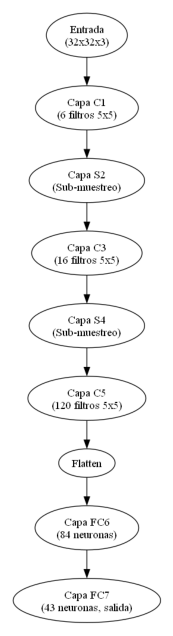

In [11]:
# Definir el modelo Le-Net
model = Sequential()
model.add(Conv2D(6, (5, 5), activation='sigmoid', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (5, 5), activation='sigmoid'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(120, (5, 5), activation='tanh'))
model.add(Flatten())
model.add(Dense(84, activation='tanh'))
model.add(Dense(43, activation='softmax'))

# Visualizar el diagrama utilizando matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(plt.imread('lenet_architecture.png'))
plt.axis('off')
plt.show()


3. **Explicar el proceso de convolución, función de activación y pooling.**


*1- Convolución:*

La convolución es una operación matemática que se realiza entre dos funciones para producir una tercera funcion. En el caso de una red neuronal convolucional, esta tercera función es una imagen filtrada que resalta algunas características de la imagen original. La convolución se hace deslizando un filtro o núcleo sobre la imagen y multiplicando y sumando los valores correspondientes.

*2-  Función de Activación:*

La función de activación es la que determina si una neurona se activa o no, es decir, si produce una señal de salida o no. La función de activación introduce no linealidad en la red, lo que le permite aprender funciones más complejas. La función de activación más usada en las redes neuronales convolucionales son sigmoid, tanh, y RElu. Sigmoid tiene un rango de valores entre 0 y 1, tanh tiene un rango de valores entre -1 y 1, y ReLU retorna 0 si el valor de entrada es negativo y el mismo valor de entrada si es positivo.

*3- Agrupamiento (Pooling):*

La capa de agrupamiento se emplea para disminuir la dimensionalidad de las características representadas y para introducir  insensibilidad a las transformaciones aplicadas a la imagen, tales como rotaciones o desplazamientos. La capa de agrupamiento aplica una operación como el máximo o el promedio a una región de la imagen, y devuelve el valor resultante. Esto permite reducir el número de parámetros y el costo computacional de la red.

**Fuentes:**

https://remolinator.com/redes-neuronales-convolucionales-cnn/
https://www.ibm.com/es-es/topics/convolutional-neural-networks
https://es.wikipedia.org/wiki/Red_neuronal_convolucional
https://sensoricx.com/conocimiento/redes-neuronales-convolucionales/


------------
### Construcción del modelo:
1. **Utilizar la biblioteca de aprendizaje profundo TensorFlow para construir la arquitectura Le-Net**

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d_12 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_22 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_13 (Avera  (None, 5, 5, 16)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_23 (Conv2D)          (None, 1, 1, 120)         48120     
                                                                 
 flatten_7 (Flatten)         (None, 120)              

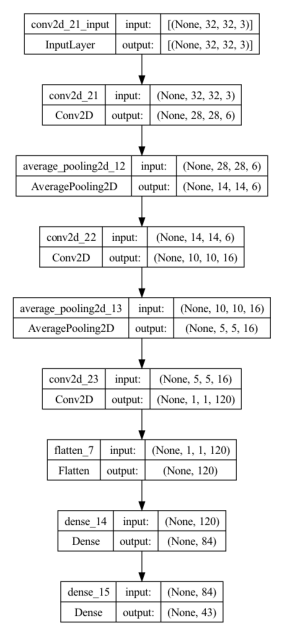

In [42]:
# Definir la arquitectura Le-Net original
model = keras.Sequential([
    layers.Conv2D(6, kernel_size=5, activation='tanh', input_shape=(32, 32, 3)),
    layers.AveragePooling2D(pool_size=2),
    layers.Conv2D(16, kernel_size=5, activation='tanh'),
    layers.AveragePooling2D(pool_size=2),
    layers.Conv2D(120, kernel_size=5, activation='tanh'),
    layers.Flatten(),
    layers.Dense(84, activation='tanh'),
    layers.Dense(43, activation='softmax')  # Cambiar 10 a 43 para ajustar el número de clases
])

# Mostrar el resumen del modelo
model.summary()

# Mostrar el diagrama del modelo
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

# Mostrar modelo.png
plt.figure(figsize=(10, 8))
plt.imshow(plt.imread('model.png'))
plt.axis('off')
plt.show()

2. **Definir la estructura de capas convolucionales, capas de pooling y capas fully connect**


Capa Conv2D (C1):
   - Filtros: 6
   - Tamaño del kernel: 5x5
   - Función de activación: 'tanh'
   - Tamaño de entrada: (32, 32, 1)
   - Esta capa representa la convolución inicial en la arquitectura Le-Net.

Capa AveragePooling2D (S2):
   - Tamaño de ventana de pooling: 2x2
   - Tipo de pooling: Promedio
   - Esta capa realiza el sub-muestreo después de la primera capa convolucional.

Capa Conv2D (C3):
   - Filtros: 16
   - Tamaño del kernel: 5x5
   - Función de activación: 'tanh'
   - Esta capa realiza otra convolución para extraer características más abstractas.

Capa AveragePooling2D (S4):
   - Tamaño de ventana de pooling: 2x2
   - Tipo de pooling: Promedio
   - Esta capa realiza otro sub-muestreo después de la segunda capa convolucional.

Capa Conv2D (C5):
   - Filtros: 120
   - Tamaño del kernel: 5x5
   - Función de activación: 'tanh'
   - Esta capa realiza la última convolución en la arquitectura Le-Net.

Capa Flatten:
   - Convierte los datos 2D en un vector 1D para la capa fully connected.

Capa Dense (FC6):
   - Neuronas: 84
   - Función de activación: 'tanh'
   - Capa fully connected que introduce no linealidad.

Capa Dense (FC7):
   - Neuronas: 43 (igual al número de clases en tu conjunto de datos)
   - Función de activación: 'softmax'
   - Capa fully connected de salida que produce las probabilidades de pertenencia a cada clase.


3. **Explicar la importancia de la función de pérdida y el optimizador.**


**Función de Pérdida:**
- La función de pérdida (también conocida como función objetivo o función de costo) mide la discrepancia entre las predicciones del modelo y los valores reales del conjunto de datos. En otras palabras, cuantifica la diferencia entre lo que el modelo predice y lo que realmente debería haber predicho. Esta es importante ya que le dice al modelo si está aprendiendo correctamente o no; si el modelo es capaz de reducir la pérdida, está aprendiendo bien.

**Optimizador:**
- El optimizador es un algoritmo que ajusta los parámetros del modelo para minimizar la función de pérdida. En otras palabras, es responsable de actualizar los pesos y sesgos de las diferentes capas del modelo para reducir gradualmente el error entre las predicciones del modelo y los valores reales. Existen varios optimizadores disponibles, cada uno con su propio enfoque para ajustar los parámetros. Este es importante ya que es el que se encarga de ajustar los pesos y sesgos de las diferentes capas del modelo para reducir gradualmente el error entre las predicciones del modelo y los valores reales.


La elección de la función de pérdida y el optimizador puede tener un impacto significativo en el rendimiento y la velocidad de entrenamiento del modelo. Una función de pérdida adecuada debe reflejar la naturaleza de la tarea y ayudar al modelo a converger hacia soluciones óptimas. Por otro lado, el optimizador debe ser capaz de ajustar los parámetros de manera eficiente y evitar quedar atrapado en mínimos locales.

En problemas de clasificación multiclase como este, donde se busca asignar una etiqueta a una de varias clases posibles, la función de pérdida más comúnmente utilizada es la **categorical_crossentropy**

El optimizador **adam** es una elección común para el entrenamiento redes neuronales convolucionales. Es una variante del descenso de gradiente estocástico que adapta automáticamente la tasa de aprendizaje durante el entrenamiento. 

**Fuente:**

https://www.tensorflow.org/tutorials/keras/classification?hl=es-419


------

### Entrenamiento del modelo:
1. **Explicar el proceso de entrenamiento de la red neuronal.**

*Recopilación y Preparación de Datos:*
   - Se reúnen y organizan los datos necesarios para la tarea que la red neuronal debe aprender.
   - Los datos se dividen en conjuntos de entrenamiento, validación y prueba.

*Definición de la Arquitectura de la Red:*
   - Se selecciona la arquitectura de la red neuronal, que incluye el número de capas, el tipo de capas (convolucionales, recurrentes, totalmente conectadas, etc.), el número de neuronas en cada capa, las funciones de activación, etc.

*Inicialización de Pesos:*
   - Los pesos y sesgos iniciales de la red se asignan de manera aleatoria o según algún método específico.

*Forward Propagation:*
   - Los datos de entrada se introducen en la red neuronal, y se propagan hacia adelante a través de las capas mediante operaciones y funciones de activación.
   - Se calculan las salidas de la red.

*Cálculo Loss Function:*
   - Se compara la salida de la red con las etiquetas reales del conjunto de entrenamiento.
   - La función de pérdida mide la diferencia entre las salidas predichas y las salidas reales.

*Backpropagation:*
   - Se calculan los gradientes de la función de pérdida con respecto a los pesos de la red utilizando el algoritmo de backpropagation.
   - Los gradientes se propagan hacia atrás a través de la red para determinar cómo los pesos deben ajustarse para minimizar la pérdida.

*Optimización de Pesos:*
   - Se utilizan algoritmos de optimización, como el descenso de gradiente, para ajustar los pesos y minimizar la función de pérdida.

*Validación y Ajuste de Hiperparámetros:*
   - Se utiliza el conjunto de validación para ajustar los hiperparámetros de la red, como la tasa de aprendizaje, etc.
   - Esto ayuda a evitar el sobreajuste y mejorar el rendimiento general de la red.

*Prueba y Evaluación:*
   - Una vez entrenada la red, se evalúa en el conjunto de prueba para medir su desempeño en datos no vistos.
   - Se pueden utilizar diversas métricas de evaluación según la tarea, como precisión, exactitud, F1-score, etc.

Fuente
https://learn.microsoft.com/es-es/archive/msdn-magazine/2019/april/artificially-intelligent-how-do-neural-networks-learn

2. **Mostrar cómo cargar los datos de entrenamiento y validación en lotes.**

En este caso, los datos de entrenamiento y validación, como se puede observar a continuación, se cargan en lotes de tamaño 32. Esto se declara en model.fit, donde se especifica el tamaño del lote. En este caso, se ha elegido un tamaño de lote de 32, ya que es un tamaño de lote comúnmente utilizado en el entrenamiento de redes neuronales. Asimismo, después de varias pruebas, se determinó que este retornaba los mejores resultados.

3. **Definir hiperparámetros como tasa de aprendizaje, número de épocas, tamaño de lote, etc**

In [48]:
learning_rate = 0.001
num_epochs = 6                  # Se escogió 6 debido a que con EarlyStopping, se detiene justamente en la 6ta época
batch_size = 32               
optimizer = 'adam'
loss_function = 'categorical_crossentropy'

# Early stopping
detencion_temprana = EarlyStopping(monitor = 'val_loss', patience = 3)

# Compilar el modelo
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

history = model.fit(
    x=train_images, y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(val_images, val_labels),
    callbacks = [detencion_temprana]
)

Epoch 1/6
1088/1088 [==============================] - 15s 12ms/step - loss: 0.0100 - accuracy: 0.9968 - val_loss: 0.4117 - val_accuracy: 0.9238
Epoch 2/6
1088/1088 [==============================] - 13s 12ms/step - loss: 0.0092 - accuracy: 0.9974 - val_loss: 0.3561 - val_accuracy: 0.9363
Epoch 3/6
1088/1088 [==============================] - 12s 11ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.2981 - val_accuracy: 0.9442
Epoch 4/6
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.3255 - val_accuracy: 0.9410
Epoch 5/6
1088/1088 [==============================] - 12s 11ms/step - loss: 0.0087 - accuracy: 0.9970 - val_loss: 0.3831 - val_accuracy: 0.9317
Epoch 6/6
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.2904 - val_accuracy: 0.9413


---------
###  Evaluación del modelo
1. **Evaluar el modelo entrenado utilizando el conjunto de prueba.**

In [47]:
import numpy as np
from sklearn.metrics import classification_report

# Obtén las predicciones del modelo en el conjunto de prueba
test_predictions = model.predict(test_images)

# Convierte las etiquetas verdaderas y las predicciones en matrices binarias
true_labels = np.argmax(test_labels, axis=1)
predicted_labels = np.argmax(test_predictions, axis=1)

# Imprimir accuracy
print('Accuracy: ', np.mean(predicted_labels == true_labels))


395/395 [==============================] - 2s 4ms/step
Accuracy:  0.9169437846397467


2. **Mostrar cómo calcular métricas de evaluación, como Precisión, Recall y F1-Score para cada clase.**

In [37]:
# Calcula el reporte de clasificación
class_names = [f'Clase {i}' for i in range(43)]
report = classification_report(true_labels, predicted_labels, target_names=class_names)

print(report)

              precision    recall  f1-score   support

     Clase 0       0.44      0.12      0.18        60
     Clase 1       0.65      0.78      0.71       720
     Clase 2       0.74      0.52      0.61       750
     Clase 3       0.70      0.78      0.74       450
     Clase 4       0.84      0.84      0.84       660
     Clase 5       0.47      0.48      0.47       630
     Clase 6       0.84      0.54      0.66       150
     Clase 7       0.58      0.61      0.60       450
     Clase 8       0.66      0.70      0.68       450
     Clase 9       0.93      0.70      0.80       480
    Clase 10       0.80      0.97      0.87       660
    Clase 11       0.89      0.93      0.91       420
    Clase 12       0.98      0.91      0.94       690
    Clase 13       0.93      0.99      0.96       720
    Clase 14       0.95      0.97      0.96       270
    Clase 15       0.92      0.87      0.89       210
    Clase 16       0.98      0.99      0.98       150
    Clase 17       0.97    